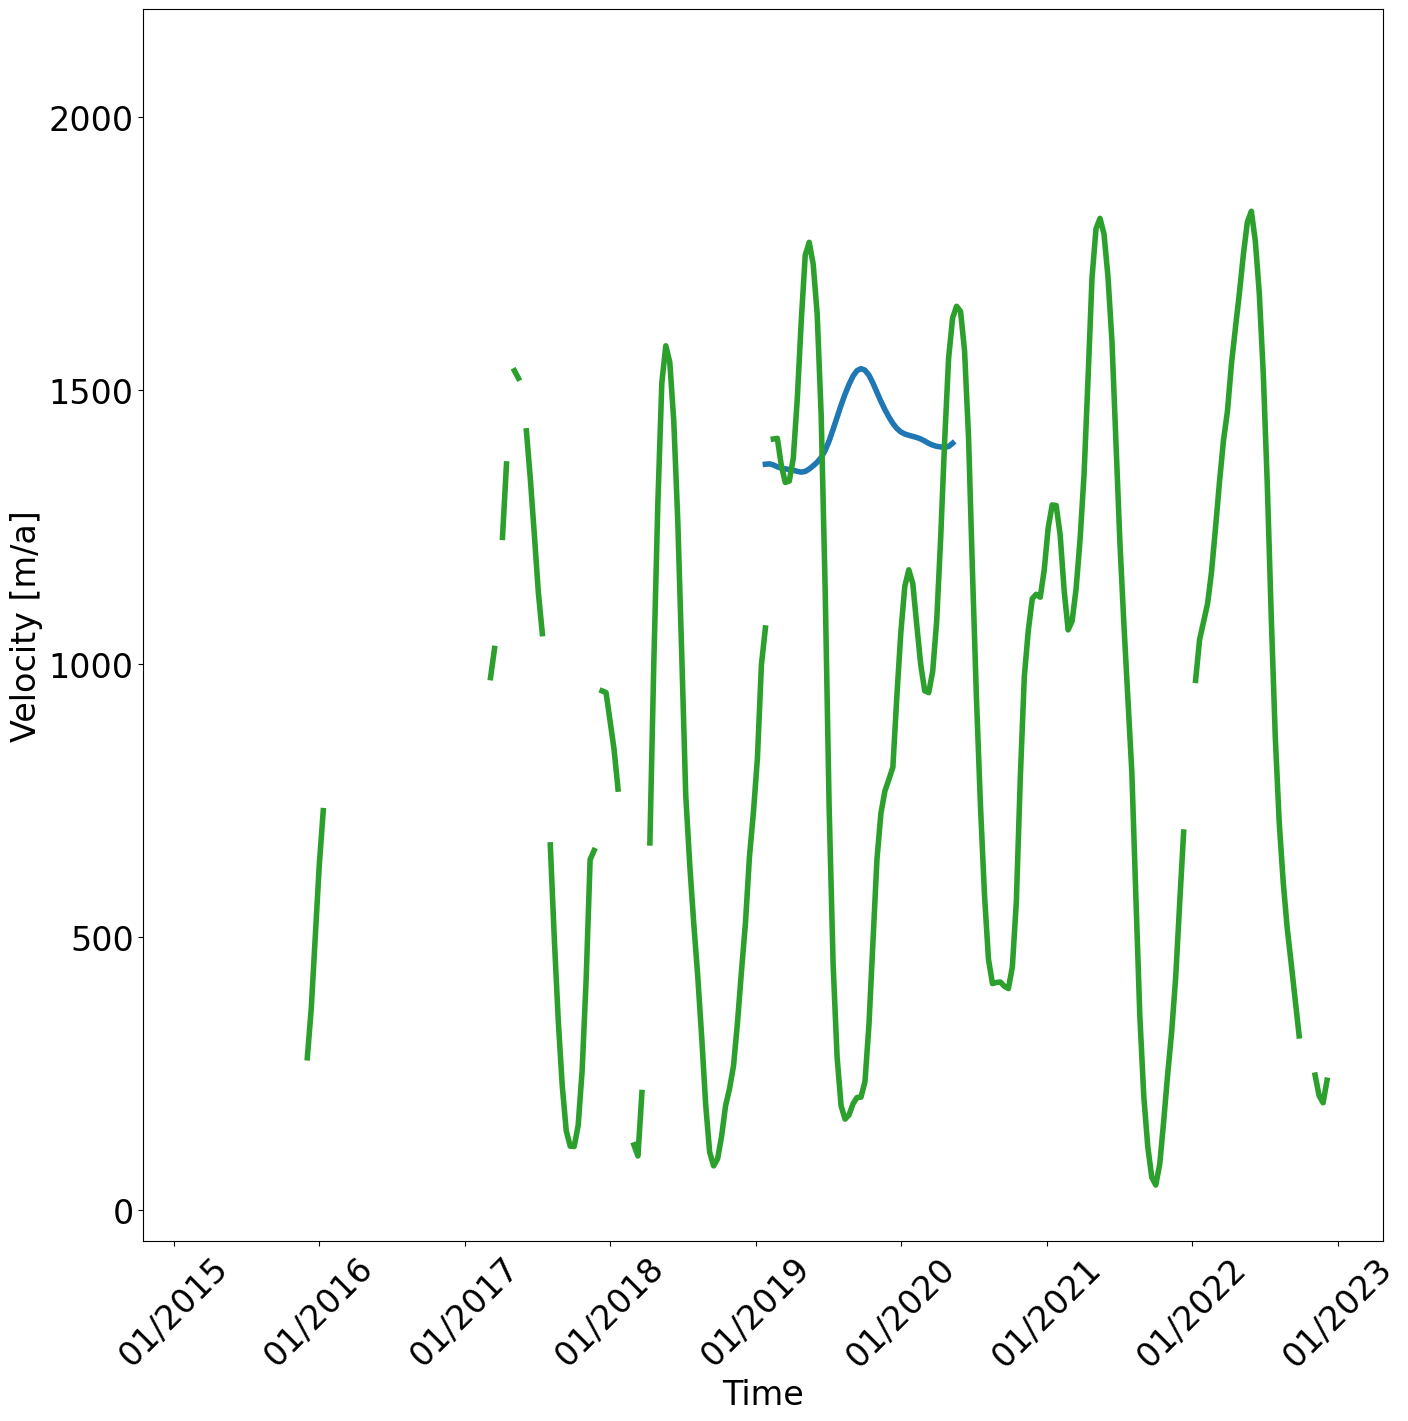

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
import scipy
import pyproj

# from tqdm import tqdm
from scipy.signal import savgol_filter

fs = 24  # font size

# Create a larger figure
fig, ax = plt.subplots(figsize=(16, 16))


########################
# open dataset
year = "2016"
hubv = xarray.open_dataset("../Hubbard_S1.nc") #("../Hubbard_sentinel1.nc") ("../Hubbard_5eminus5.nc") 

########################
# load coordinates of points for velocity plots
points = pd.read_csv("centerline_points_3000m.csv")  # this is in ESPG: 3413

# coordinates of points of interest
# points_X = np.array([points.X[1], points.X[5]])  # specify your target x coordinate
# points_Y = np.array([points.Y[1], points.Y[5]])  # specify your target y coordinate

# dense points around ice fall

# load coordinates of points for velocity plots
points = pd.read_csv("centerline_points_1000m.csv")  # this is in ESPG: 3413

points_X = np.array([points.X[13], points.X[7]])  # specify your target x coordinate
points_Y = np.array([points.Y[13], points.Y[7]])  # specify your target y coordinate

points_X = np.array([points.X[10], points.X[8]])  # specify your target x coordinate
points_Y = np.array([points.Y[10], points.Y[8]])  # specify your target y coordinate


########################
# get velocities at these locations from velocity datacube

ns_in_day = 60 * 60 * 24 * 1e9
epoch = np.datetime64("%s-01-01" % year)
t = ((hubv.time[:] - epoch).to_numpy() / ns_in_day).astype(np.float32)

# Convert time values to datetime objects
datetime_index = pd.to_datetime(hubv.time.values)

# time series for each point
vx = np.zeros((points_X.shape[0], hubv.vx.shape[0]))
vy = np.zeros((points_X.shape[0], hubv.vx.shape[0]))
v = np.zeros((points_X.shape[0], hubv.vx.shape[0]))
 
for i in range(len(points_X)):
    # get indices of coordinates closest to points of interest
    target_x_idx = np.abs(hubv.x.values - points_X[i]).argmin()
    target_y_idx = np.abs(hubv.y.values - points_Y[i]).argmin()

    # Extract the time series closest to the target coordinates
    vx[i, :] = hubv.vx[:, target_y_idx, target_x_idx]
    vy[i, :] = hubv.vy[:, target_y_idx, target_x_idx]
    v[i] = np.sqrt(vx[i] ** 2 + vy[i] ** 2)

    n = 60
    velocity = np.convolve(np.ones(n) / n, v[i, :], mode="same")

    # plot time series at points
    ax.plot(datetime_index, velocity, linewidth=4)

# Define the coordinate systems for conversion
epsg_32607 = pyproj.CRS("EPSG:32607")  # UTM zone 7N, WGS 84
epsg_3413 = pyproj.CRS("EPSG:3413")    # NSIDC Sea Ice Polar Stereographic North

# Define the transformer for the conversion
transformer = pyproj.Transformer.from_crs(epsg_32607, epsg_3413, always_xy=True)

# Valerie
x_32607 = 586400  # X coordinate
y_32607 = 6658400  # Y coordinate

#Hubbard point
# x_32607 = 590400  # X coordinate
# y_32607 = 6657500  # Y coordinate

# Perform the conversion to EPSG:3413
x_3413, y_3413 = transformer.transform(x_32607, y_32607)

target_valerie_x = np.abs(hubv.x.values - x_3413).argmin()
target_valerie_y = np.abs(hubv.y.values - y_3413).argmin()

valerie_vx = hubv.vx[:, target_valerie_y, target_valerie_x]
valerie_vy = hubv.vy[:, target_valerie_y, target_valerie_x]
valerie_v = np.sqrt(valerie_vx ** 2 + valerie_vy ** 2)

ax.plot(datetime_index, valerie_v, linewidth=4)

# Set x-axis label
ax.set_xlabel("Time", fontsize=fs)

# Set y-axis label
ax.set_ylabel("Velocity [m/a]", fontsize=fs)

# Set font size for tick labels
ax.tick_params(axis="both", which="major", labelsize=fs)

# Format x-axis to display month/year
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%Y"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

########################

# Get all text objects in the figure
text_objs = plt.gcf().findobj(plt.Text)

# Change font size for all text objects
font_size = fs  # Change this to the font size you desire
for text_obj in text_objs:
    text_obj.set_fontsize(font_size)

plt.savefig("multiyear_centerline_velocities.png")
